# FD001 Branch 2: LSTM-50 기반 Phase 1 개선 실험

## 📋 실험 개요

- **Dataset**: FD001
- **Best Model from Branch 1**: LSTM-50 (Test RMSE: 37.23, R²: 0.49)
- **실험 목적**: Phase 1 개선 기법들의 효과 검증

---

## 🎯 4가지 실험 조건

1. **Baseline**: 개선 없음 (원본 데이터)
2. **RUL Clipping**: RUL ≤ 125로 제한
3. **Sensor Removal**: Noise 센서 8개 제거
4. **Both**: RUL Clipping + Sensor Removal 동시 적용

---

## 📊 제거 대상 Noise 센서

```python
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']
```

## 1. 환경 설정 및 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

## 2. 데이터 로드 및 스케일링

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.preprocessing import StandardScaler

# 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# FD001 데이터 로드
train_fd001 = pd.read_csv(f'{DATA_PATH}/FD001_train_df.csv')
test_fd001 = pd.read_csv(f'{DATA_PATH}/FD001_test_df.csv')

## 3. 센서 컬럼 정의 및 스케일링

In [4]:
# Noise 센서 정의
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']

# 전체 센서 (21개)
ALL_SENSORS = [f's_{i}' for i in range(1, 22)]

# 신호 센서 (Noise 제거 후 13개)
SIGNAL_SENSORS = [s for s in ALL_SENSORS if s not in NOISE_SENSORS]

In [5]:
train_baseline = train_fd001.copy()
test_baseline = test_fd001.copy()

scaler_baseline = StandardScaler()
train_baseline[ALL_SENSORS] = scaler_baseline.fit_transform(train_fd001[ALL_SENSORS])
test_baseline[ALL_SENSORS] = scaler_baseline.transform(test_fd001[ALL_SENSORS])

train_clipped = train_fd001.copy()
train_clipped['RUL'] = train_clipped['RUL'].clip(upper=125)
test_clipped = test_fd001.copy()
test_clipped['RUL'] = test_clipped['RUL'].clip(upper=125)

scaler = StandardScaler()
train_fd001_scaled = train_clipped.copy()
train_fd001_scaled[ALL_SENSORS] = scaler.fit_transform(train_clipped[ALL_SENSORS])
test_fd001_scaled = test_clipped.copy()
test_fd001_scaled[ALL_SENSORS] = scaler.transform(test_clipped[ALL_SENSORS])

## 4. 데이터 전처리 함수

In [6]:
def apply_rul_clipping(df, max_rul=125):
    df_clipped = df.copy()
    df_clipped['RUL'] = df_clipped['RUL'].clip(upper=max_rul)
    return df_clipped

def remove_noise_sensors(df, noise_sensors):
    cols_to_keep = [col for col in df.columns if col not in noise_sensors]
    return df[cols_to_keep].copy()

def create_sequences(df, sensor_cols, window_size=50):
    X, y = [], []

    for unit_id in df['unit'].unique():
        unit_data = df[df['unit'] == unit_id].sort_values('cycle')

        sensor_values = unit_data[sensor_cols].values
        rul_values = unit_data['RUL'].values

        for i in range(len(sensor_values) - window_size + 1):
            X.append(sensor_values[i:i+window_size])
            y.append(rul_values[i+window_size-1])

    return np.array(X), np.array(y)

## 5. LSTM 모델 정의

In [7]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(25),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

## 6. 실험 실행 함수

In [8]:
def run_experiment(train_data, test_data, sensor_cols, condition_name, window_size=50):
    # 시퀀스 데이터 생성
    X_train, y_train = create_sequences(train_data, sensor_cols, window_size)
    X_test, y_test = create_sequences(test_data, sensor_cols, window_size)

    # Train/Validation 분할
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, shuffle=False
    )

    # 모델 생성
    model = build_lstm_model(input_shape=(window_size, len(sensor_cols)))

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # 모델 학습
    history = model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=100,
        batch_size=128,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    epochs_trained = len(history.history['loss'])
    stopped_early = epochs_trained < 100

    # 예측
    y_train_pred = model.predict(X_train, verbose=0).flatten()
    y_test_pred = model.predict(X_test, verbose=0).flatten()

    # 평가
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'condition': condition_name,
        'n_sensors': len(sensor_cols),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
    }

## 7. 4가지 실험 조건 실행

### 7.1 Condition 1: Baseline (전처리 없음)

In [9]:
result_baseline = run_experiment(
    train_data=train_baseline,
    test_data=test_baseline,
    sensor_cols=ALL_SENSORS,
    condition_name='1. Baseline')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 85: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 91.


### 7.2 Condition 2: RUL Clipping

In [10]:
# RUL Clipping 적용 (스케일링된 데이터 사용)
train_clipped = apply_rul_clipping(train_fd001_scaled, max_rul=125)
test_clipped = apply_rul_clipping(test_fd001_scaled, max_rul=125)

result_rul = run_experiment(
    train_data=train_clipped,
    test_data=test_clipped,
    sensor_cols=ALL_SENSORS,
    condition_name='2. RUL Clipping'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 71.


### 7.3 Condition 3: Sensor Removal

In [11]:
# Noise 센서 제거 (스케일링된 데이터 사용)
train_no_noise = remove_noise_sensors(train_fd001_scaled, NOISE_SENSORS)
test_no_noise = remove_noise_sensors(test_fd001_scaled, NOISE_SENSORS)

result_sensor = run_experiment(
    train_data=train_no_noise,
    test_data=test_no_noise,
    sensor_cols=SIGNAL_SENSORS,
    condition_name='3. Sensor Removal'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 68.


### 7.4 Condition 4: Both (RUL Clipping + Sensor Removal)

In [12]:
# Both: RUL Clipping + Sensor Removal (스케일링된 데이터 사용)
train_both = apply_rul_clipping(train_fd001_scaled, max_rul=125)
train_both = remove_noise_sensors(train_both, NOISE_SENSORS)

test_both = apply_rul_clipping(test_fd001_scaled, max_rul=125)
test_both = remove_noise_sensors(test_both, NOISE_SENSORS)

result_both = run_experiment(
    train_data=train_both,
    test_data=test_both,
    sensor_cols=SIGNAL_SENSORS,
    condition_name='4. Both'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 93: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 78.


## 8. 결과 비교 및 시각화

In [13]:
# 결과 정리
results = [result_baseline, result_rul, result_sensor, result_both]
df_results = pd.DataFrame(results)

# 개선율 계산
baseline_rmse = df_results.loc[0, 'test_rmse']
df_results['improvement_%'] = ((baseline_rmse - df_results['test_rmse']) / baseline_rmse * 100).round(2)

df_results

,condition,n_sensors,train_rmse,test_rmse,test_mae,test_r2,improvement_%
0,1. Baseline,21,23.812472,35.262677,24.500771,0.543726,0.00
1,2. RUL Clipping,21,8.813827,15.448355,12.260303,0.757075,56.19
2,3. Sensor Removal,13,9.274138,16.462772,13.378675,0.724125,53.31
3,4. Both,13,7.874628,16.193319,12.637521,0.733082,54.08


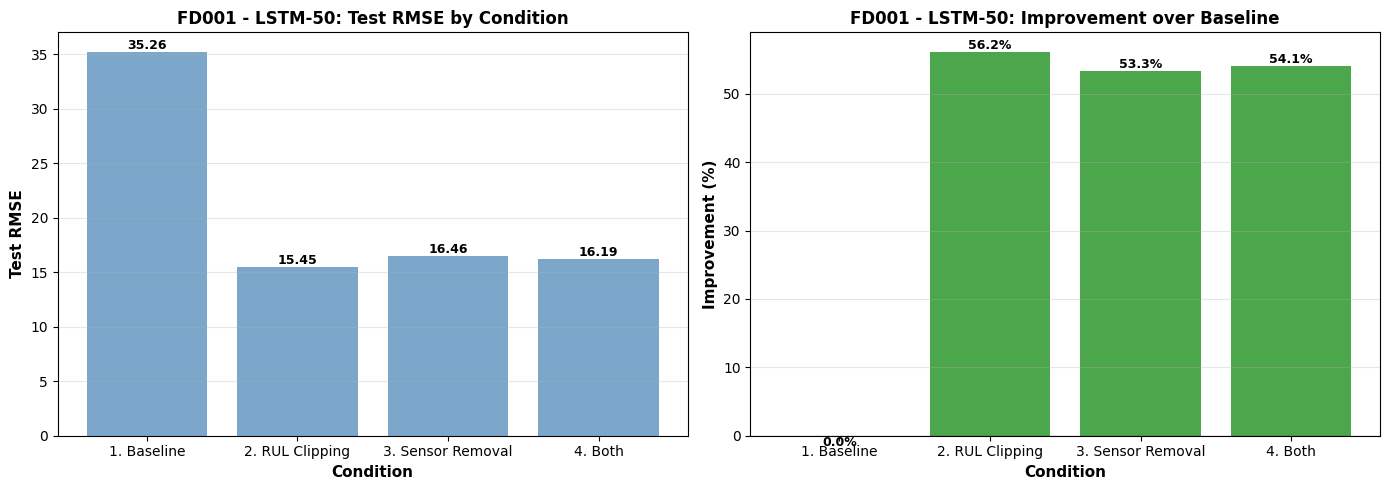

In [14]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test RMSE 비교
ax1 = axes[0]
bars1 = ax1.bar(df_results['condition'], df_results['test_rmse'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Condition', fontsize=11, fontweight='bold')
ax1.set_ylabel('Test RMSE', fontsize=11, fontweight='bold')
ax1.set_title('FD001 - LSTM-50: Test RMSE by Condition', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x')

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 개선율 비교
ax2 = axes[1]
colors = ['gray' if x == 0 else 'green' if x > 0 else 'red' for x in df_results['improvement_%']]
bars2 = ax2.bar(df_results['condition'], df_results['improvement_%'], color=colors, alpha=0.7)
ax2.set_xlabel('Condition', fontsize=11, fontweight='bold')
ax2.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
ax2.set_title('FD001 - LSTM-50: Improvement over Baseline', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x')

# 값 표시
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()